# PILLS archival snapshot

In this analysis, we will locate PILLS held by contracts on the Fantom DAG.

This analysis occurs in the context of two other sets of findings:

- a snapshot of PILLS address balances (obtained from the PILLS ERC-20 contract)
- a snapshot of Neo Pools PILLS balances (obtained from Neo Pools contracts)

The current analysis will examine Liquidity Pool contracts that hold PILLS on behalf of LP providers.
Raw data were obtained by performing queries against a Fantom Full Archival RPC node.

In [106]:
import os
import json
import time
from pprint import pprint
from dotenv import load_dotenv
import pandas as pd
import web3

load_dotenv(os.path.expanduser('~/Work/morpheus-swap/.env'))
w3 = web3.Web3(web3.Web3.HTTPProvider(os.environ['FANTOM_WEB3_PROVIDER_URI']))

# load ABIs for the contract methods we'll use
with open(os.path.join(os.environ['DATA_PATH'], 'abis.json'), 'r') as f:
    abis = json.load(f)

## Contract details

### PILLS

The quantity of PILLS held by an address at the time of the snapshot can be queried with the PILLS ERC-20 `balanceOf()` method.

- ERC-20:
    - 0xB66b5D38E183De42F21e92aBcAF3c712dd5d6286
    - https://ftmscan.com/address/0xB66b5D38E183De42F21e92aBcAF3c712dd5d6286

In [76]:
pills_erc20_contract = w3.eth.contract(
    address=web3.Web3.toChecksumAddress('0xb66b5d38e183de42f21e92abcaf3c712dd5d6286'),
    abi=[abis["erc20_balance_of"]]
)

## Neo Pools

There are many NeoPools contracts - but they all have the same interface.
The following address corresponds to the NeoPool contract deployed April 12, 2022.

- NeoPool:
    - 0x326A7D91B6F767458599E7d93DFc850d2e083d30
    - https://ftmscan.com/address/0x326A7D91B6F767458599E7d93DFc850d2e083d30

In [77]:
neopool_contract = w3.eth.contract(
    address=web3.Web3.toChecksumAddress('0x326A7D91B6F767458599E7d93DFc850d2e083d30'),
    abi=json.dumps([abis["neopool_user_info"]])
)

# Load all Neo Pools and examine the 3 most-recent contract addresses
with open(os.path.join(os.environ['DATA_PATH'], 'neo-pools.json'), 'r') as f:
    neo_pool_addresses = json.load(f)
neo_pool_addresses.reverse()
pprint(neo_pool_addresses[:3])

[{'address': '0x5bcb5f2ed10ac292c9e281c5ead4f0533666c3b6', 'name': 'WFTM'},
 {'address': '0x326A7D91B6F767458599E7d93DFc850d2e083d30', 'name': 'WFTM'},
 {'address': '0xA431fDd6d23f0d7C4b4B92F4aD866a5939b53abB', 'name': 'WFTM'}]


### Spirit

Any PILLS used to provide liquidity on Spirit Swap can be identified by calling `userInfo()` on the Spirit MasterChefV2 contract.

- Proxy Contract for MasterChefV2:
    - 0x6e2ad6527901c9664f016466b8DA1357a004db0f
    - https://ftmscan.com/address/0x6e2ad6527901c9664f016466b8DA1357a004db0f
    - userInfo(uint256 pid=35, address wallet_address)
    - PILLS-FTM gauge pid: 35
- MasterChefV2
    - 0x5CEE2988184afE3CD807e0178B394259E8cdC56C
    - https://ftmscan.com/address/0x5CEE2988184afE3CD807e0178B394259E8cdC56C
- PILLS-FTM Spirit LP ERC-20
    - 0x9C775D3D66167685B2A3F4567B548567D2875350
    - https://ftmscan.com/address/0x9C775D3D66167685B2A3F4567B548567D2875350

In [78]:
spirit_pills_ftm_gauge_id = 35

spirit_masterchef_contract = w3.eth.contract(
    address=web3.Web3.toChecksumAddress('0x6e2ad6527901c9664f016466b8DA1357a004db0f'),
    abi=json.dumps([abis["masterchef_user_info"]])
)

### Beethoven

To identify the PILLS tokens held by the Beethoven X Vault on behalf of an address:

1. Query the Vault to determine the total number of tokens in the PILLS-FTM Pool
2. Query the Pool for each address to determine its proportional stake

- WeightedPool2Tokens:
    - 0x93c7dEfE51D787010BABfDB19504D5A72166E112
    - https://ftmscan.com/address/0x93c7dEfE51D787010BABfDB19504D5A72166E112
    - "I took PILLS in Ibiza"
    - 80-20 PILLS-FTM
- Balancer Vault:
    - 0x20dd72ed959b6147912c2e529f0a0c651c33c9ce
    - https://ftmscan.com/address/0x20dd72ed959b6147912c2e529f0a0c651c33c9ce
    - getPoolTokens(bytes32 pool_id=0x93c7defe51d787010babfdb19504d5a72166e11200020000000000000000041c)
    - getPool(bytes32 pool_id=0x93c7defe51d787010babfdb19504d5a72166e11200020000000000000000041c)

In [81]:
beethoven_pills_ftm_pool_id = '0x93c7defe51d787010babfdb19504d5a72166e11200020000000000000000041c'

beethoven_pills_ftm_lp_contract = w3.eth.contract(
    address=web3.Web3.toChecksumAddress('0x93c7dEfE51D787010BABfDB19504D5A72166E112'),
    abi=json.dumps([abis["erc20_balance_of"]])
)

beethoven_vault_contract = w3.eth.contract(
    address=web3.Web3.toChecksumAddress('0x20dd72ed959b6147912c2e529f0a0c651c33c9ce'),
    abi=json.dumps([abis["balancer_get_pool_tokens"]])
)

## Snapshot Block

Block number 36490006 was identified for the snapshot by scanning for the first block with a PILLS transaction that occurred on April 20, 2022.

https://ftmscan.com/block/36490006

In [110]:
block_number_snapshot = 36490006

## Addresss

The addresses used in this analysis were obtained by identifying every address to interact with the PILLS ERC-20 contract.
For example, any time an address invokes the PILLS ERC-20 `approve()` method, this would be recorded in the Fantom DAG as a transaction from a "wallet" address to the PILLS ERC-20 contract.

Another common contract interaction involves the PILLS `transfer()` method, which can be called either directly or indirectly.
When `transfer()` is called directly from an address, the entire transaction generally consists of a single instruction that invokes the `transfer()` method.
PILLS may also be transferred indirectly - within a transaction - which for example occurs when tokens are swapped, during certain compounding operations, etc.

We obtained all direct interactions with the PILLS ERC-20 by examining all transactions confirmed by the Fantom DAG, selecting those with the PILLS address as the value in the transaction `to` field.
We obtained indirect, internal transaction `transfer()` invocations from Luabase, which *they* obtained by "replaying" all Fantom transactions using an Ethereum Virtual Machine (EVM) then storing the intermediate results.

Altogether, this method identified addresses that could potentially be PILLS holders in April, 2022.
This list of addresses is used as the source for querying other contracts in order to identify holdings with those contracts.

In [86]:
# load all PILLS transactions
df_txs = pd.read_csv(os.path.join(os.environ['DATA_PATH'], 'pills-txs.csv'))
transaction_from_unique = set([ web3.Web3.toChecksumAddress(a) for a in df_txs['from'].unique() ])

# load all PILLS ERC-20 transfers, as computed by Luabase
df_transfers = pd.read_csv(os.path.join(os.environ['DATA_PATH'], 'pills-transfers.csv'))
transfer_from_unique = set([ web3.Web3.toChecksumAddress(a) for a in df_transfers['from'].unique() ])
transfer_to_unique = set([ web3.Web3.toChecksumAddress(a) for a in df_transfers['to'].unique() ])

# identify unique addresses among PILLS transactions and transfers
addresses = list(transfer_from_unique.union(transfer_to_unique).union(transaction_from_unique))
print(f"Identified {len(addresses)} addresses that interacted with PILLS ERC-20 contract")
print("Sanity check: ensure the first 5 addresses look reasonable.")
pprint(addresses[:5])

# save addresses for later
with open(os.path.join(os.environ['DATA_PATH'], 'pills-addresses.json'), 'w') as f:
    json.dump(addresses, f)

Identified 10151 addresses that interacted with PILLS ERC-20 contract
Sanity check: ensure the first 5 addresses look reasonable.
['0xD488F4585Ab28D003324253be5D791aC103c0b57',
 '0x4BC4Da7839a3c987D44F0DBDAcBDd1f53243Ba24',
 '0xD3743Ec801f157FBfF93FcC813fdBA231026cBF2',
 '0xA5085a73A793ab3Db27E934759Ba4C0225af3eF5',
 '0xE1e96F427297C1A7c597cAEDF127D7906F1f2794']


## PILLS ERC-20 Balances

In [57]:
results = []
count = 0

for address in addresses:
    balance = pills_erc20_contract.functions.balanceOf(address).call(block_identifier=block_number_snapshot)
    row = {
        'address': address,
        'balance': balance,
    }
    results.append(row)
    
    count += 1
    time.sleep(0.2)
    if count > 2:
        break   

df = pd.DataFrame(data=results)
# df.to_csv(os.path.join(os.environ['DATA_PATH'], '2022-04-15-pills-erc20-balance.csv'), index=False)

## Neo Pools

## Spirit PILLS-FTM LP

In [82]:
results = []
count = 0

for address in addresses:
    amount, reward_debt = spirit_masterchef_contract.functions.userInfo(spirit_pills_ftm_gauge_id, address).call(block_identifier=block_number_snapshot)
    row = {
        'address': address,
        'amount': amount,
        'reward_debt': reward_debt,
    }
    results.append(row)
    break

df = pd.DataFrame(data=results)
# df.to_csv(os.path.join(os.environ['DATA_PATH'], '2022-04-15-pills-spirit-lp-balance.csv'), index=False)

## Beethoven X LP

In [111]:
results = []
count = 0

# first determine total tokens in pool
tokens, balances, last_change_block = beethoven_vault_contract.functions.getPoolTokens(beethoven_pills_ftm_pool_id).call(block_identifier=block_number_snapshot)
print(f"""
Tokens:   {tokens}
Balances: {[b/10**18 for b in balances]}
""")

for address in addresses:
    balance = beethoven_pills_ftm_lp_contract.functions.balanceOf(address).call(block_identifier=block_number_snapshot)
    row = {
        'address': address,
        'balance': balance,
    }
    results.append(row)
    break

df = pd.DataFrame(data=results)
print(df)
# df.to_csv(os.path.join(os.environ['DATA_PATH'], '2022-04-15-pills-spirit-lp-balance.csv'), index=False)


Tokens:   ['0xB66b5D38E183De42F21e92aBcAF3c712dd5d6286', '0xC3BF643799237588b7a6B407B3fc028Dd4e037d2']
Balances: [206361.96855477028, 15985.378200122756]

                                      address  balance
0  0xD488F4585Ab28D003324253be5D791aC103c0b57        0


## Transform results for analysis

In [126]:
with open(os.path.join(os.environ['DATA_PATH'], '2022-04-20-pills-contracts.json'), 'r') as f:
    results = json.load(f)

df = pd.DataFrame.from_dict(results)

# unpack neo pool 0
df['neo_pool_0_amount'] = [ a for a, b in df['neo_pool_0_contract'] ]
df['neo_pool_0_reward_debt'] = [ b for a, b in df['neo_pool_0_contract'] ]
del df['neo_pool_0_contract']

# unpack neo pool 1
df['neo_pool_1_amount'] = [ a for a, b in df['neo_pool_1_contract'] ]
df['neo_pool_1_reward_debt'] = [ b for a, b in df['neo_pool_1_contract'] ]
del df['neo_pool_1_contract']

# unpack spirit masterchef
df['spirit_amount'] = [ a for a, b in df['spirit_masterchef_contract'] ]
df['spirit_reward_debt'] = [ b for a, b in df['spirit_masterchef_contract'] ]
del df['spirit_masterchef_contract']

# convert all integers to floats at 18 digits precision
df = df.transform(lambda x: x / 10**18)

df.reset_index(inplace=True)
df = df.rename(columns = {'index':'address'})

df.to_csv(os.path.join(os.environ['DATA_PATH'], '2022-04-20-pills-contracts.csv'), index=False)
df

,address,pills_erc20_balance,beets_lp_erc20_balance,neo_pool_0_amount,neo_pool_0_reward_debt,neo_pool_1_amount,neo_pool_1_reward_debt,spirit_amount,spirit_reward_debt
0,0x9C775D3D66167685B2A3F4567B548567D2875350,2415931.031846,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0xF04588329c3104779796F279A9df3803Ae83dB7B,0.0,0.0,50659.89495,1463.820474,0.0,0.0,0.0,0.0
2,0x326A7D91B6F767458599E7d93DFc850d2e083d30,2882332.97636,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0x2728e32174FC95De00695007c9134fA03dC8b434,0.0,0.0,53376.318198,1611.750893,0.0,0.0,0.0,0.0
4,0xD488F4585Ab28D003324253be5D791aC103c0b57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10146,0x763B0d75770384eAc25D1b7a604A57f074FC50Ae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10147,0xC237cc36B09505C9CfF97f4847010716c0D70ea6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10148,0xc7BF7E22eD98404dE1802d0d0d1844BE21394685,67.293676,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10149,0x113C4e9AAFBDf9DfA20b01e9c0c5b38a8B9fFDdC,0.666471,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## PILLS balances

Let's examine the distribution of PILLS across these addresses.

<AxesSubplot: title={'center': "Hodler Distribution: PILLS ERC-20 ('wallet') Balances at block 36490006"}, ylabel='pills_erc20_balance'>

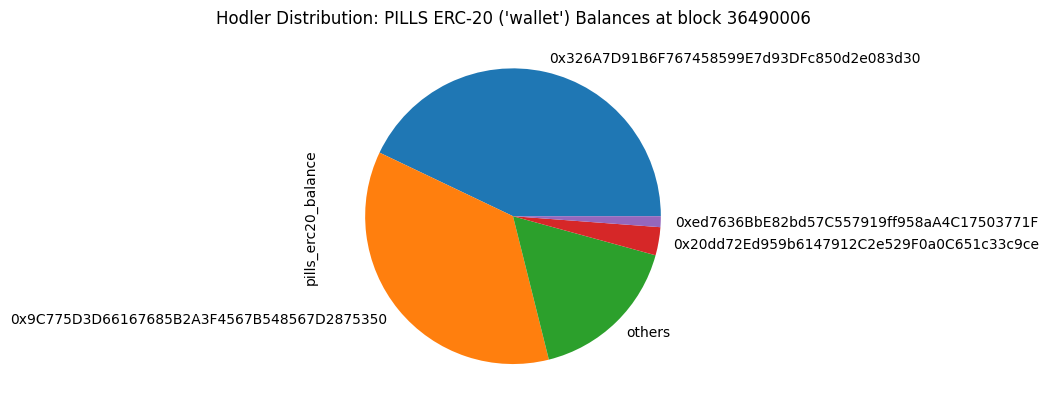

In [134]:
df_draw = df.copy()
df_draw.loc[df_draw['pills_erc20_balance'] < 50000, 'address'] = 'others'
df_draw = df_draw.groupby('address')['pills_erc20_balance'].sum().reset_index()
df_draw = df_draw.sort_values(by='pills_erc20_balance', ascending=False)
df_draw = df_draw.set_index('address')
# print(df_draw.head())
df_draw.plot.pie(y='pills_erc20_balance', title=f"Hodler Distribution: PILLS ERC-20 ('wallet') Balances at block {block_number_snapshot}", legend=False)

## Neo Pool deployed April 12

<AxesSubplot: title={'center': 'Hodler Distribution: April 12 Neo Pool Balances at block 36490006'}, ylabel='neo_pool_0_amount'>

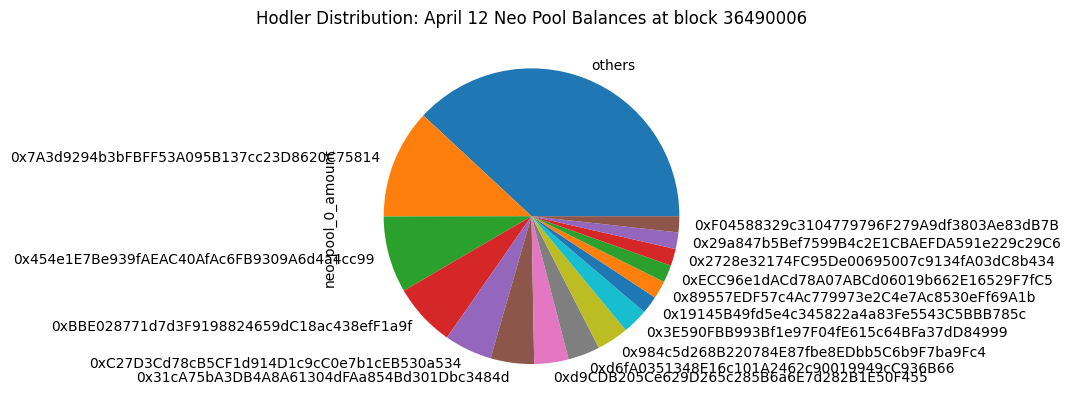

In [135]:
df_draw = df.copy()
df_draw.loc[df_draw['neo_pool_0_amount'] < 50000, 'address'] = 'others'
df_draw = df_draw.groupby('address')['neo_pool_0_amount'].sum().reset_index()
df_draw = df_draw.sort_values(by='neo_pool_0_amount', ascending=False)
df_draw = df_draw.set_index('address')
# print(df_draw.head())
df_draw.plot.pie(y='neo_pool_0_amount', title=f"Hodler Distribution: April 12 Neo Pool Balances at block {block_number_snapshot}", legend=False)

## Neo Pool deployed April 6

<AxesSubplot: title={'center': 'Hodler Distribution: April 6 Neo Pool Balances at block 36490006'}, ylabel='neo_pool_1_amount'>

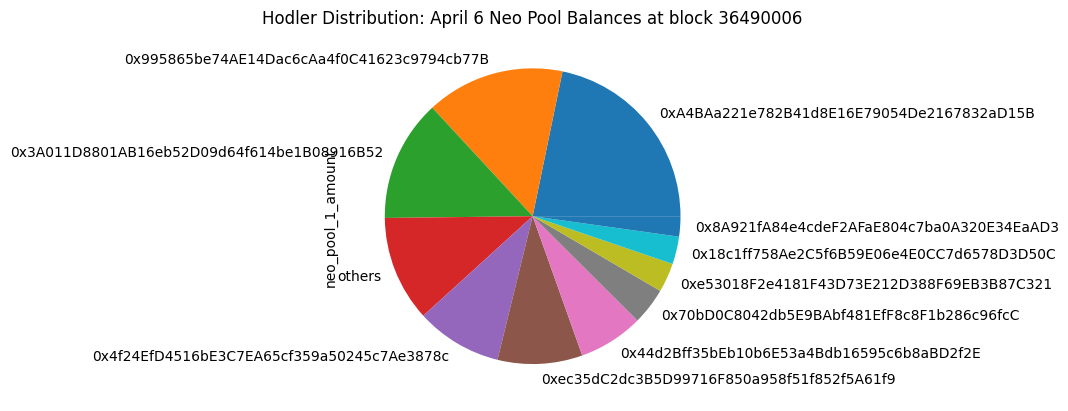

In [136]:
df_draw = df.copy()
df_draw.loc[df_draw['neo_pool_1_amount'] < 500, 'address'] = 'others'
df_draw = df_draw.groupby('address')['neo_pool_1_amount'].sum().reset_index()
df_draw = df_draw.sort_values(by='neo_pool_1_amount', ascending=False)
df_draw = df_draw.set_index('address')
# print(df_draw.head())
df_draw.plot.pie(y='neo_pool_1_amount', title=f"Hodler Distribution: April 6 Neo Pool Balances at block {block_number_snapshot}", legend=False)

## Spirit PILLS-FTM LP

<AxesSubplot: title={'center': 'Hodler Distribution: Spirit PILLS-FTM LP at block 36490006'}, ylabel='spirit_amount'>

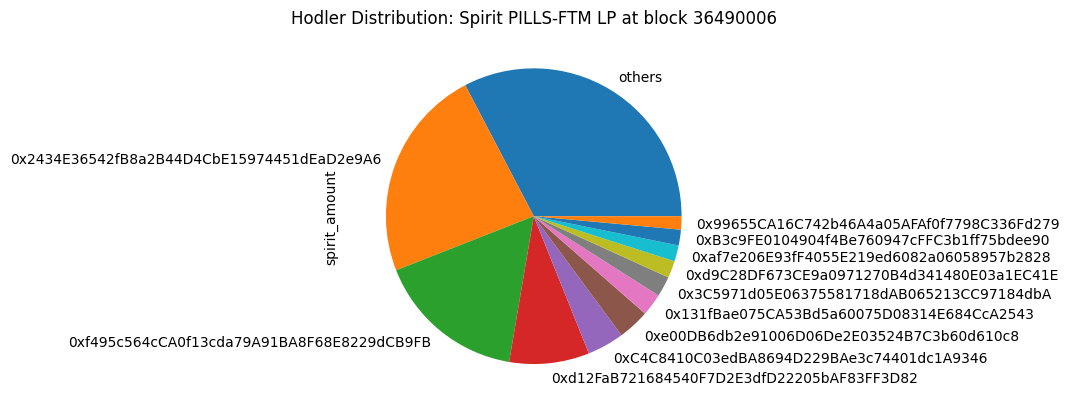

In [141]:
df_draw = df.copy()
df_draw.loc[df_draw['spirit_amount'] < 15000, 'address'] = 'others'
df_draw = df_draw.groupby('address')['spirit_amount'].sum().reset_index()
df_draw = df_draw.sort_values(by='spirit_amount', ascending=False)
df_draw = df_draw.set_index('address')
# print(df_draw.head())
df_draw.plot.pie(y='spirit_amount', title=f"Hodler Distribution: Spirit PILLS-FTM LP at block {block_number_snapshot}", legend=False)

## Beethoven X PILLS-FTM LP

<AxesSubplot: title={'center': 'Hodler Distribution: Beets PILLS-FTM LP at block 36490006'}, ylabel='beets_lp_erc20_balance'>

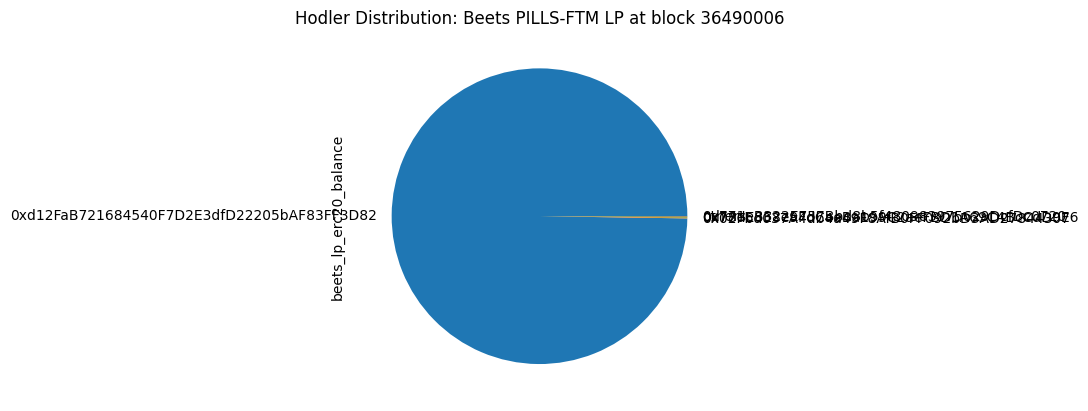

In [152]:
df_draw = df.copy()
df_draw.loc[df_draw['beets_lp_erc20_balance'] < 0.1, 'address'] = 'others'
df_draw = df_draw.groupby('address')['beets_lp_erc20_balance'].sum().reset_index()
df_draw = df_draw.sort_values(by='beets_lp_erc20_balance', ascending=False)
df_draw = df_draw.set_index('address')
# print(df_draw.head())
df_draw.plot.pie(y='beets_lp_erc20_balance', title=f"Hodler Distribution: Beets PILLS-FTM LP at block {block_number_snapshot}", legend=False)